Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 498, 16)           64        
                                                                 
 max_pooling1d (MaxPooling1  (None, 249, 16)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 247, 32)           1568      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 123, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 121, 64)           6208      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 60, 64)            0

C:\Users\S.A.N\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 93ms/step - loss: 0.8039 - accuracy: 0.6302 - val_loss: 0.7280 - val_accuracy: 0.6185
Epoch 3/20
10/10 [==============================] - 1s 93ms/step - loss: 0.6607 - accuracy: 0.6952 - val_loss: 0.6121 - val_accuracy: 0.7037
Epoch 4/20
10/10 [==============================] - 1s 87ms/step - loss: 0.5783 - accuracy: 0.7254 - val_loss: 0.5252 - val_accuracy: 0.7593
Epoch 5/20
10/10 [==============================] - 1s 96ms/step - loss: 0.4400 - accuracy: 0.8190 - val_loss: 0.4246 - val_accuracy: 0.8185
Epoch 6/20
10/10 [==============================] - 1s 79ms/step - loss: 0.4197 - accuracy: 0.8254 - val_loss: 0.5281 - val_accuracy: 0.7519
Epoch 7/20
10/10 [==============================] - 1s 89ms/step - loss: 0.4126 - accuracy: 0.8270 - val_loss: 0.3790 - val_accuracy: 0.8481
Epoch 8/20
10/10 [==============================] - 1s 79ms/step - loss: 0.3440 - accuracy: 0.8429 - val_loss: 0.4075 - val_accuracy: 0.8370
Epoch 9/20
10/10 [======

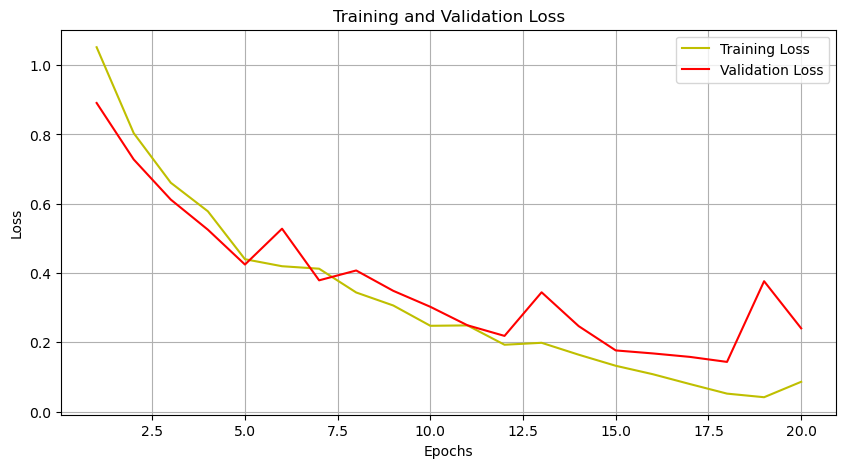

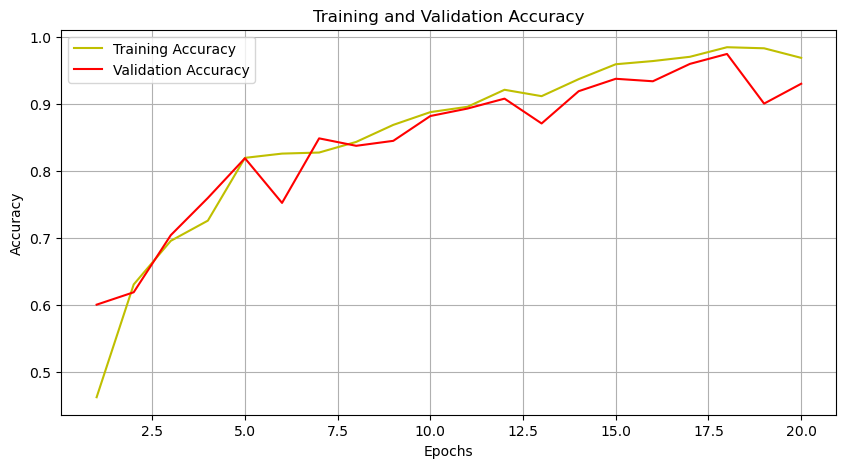

9/9 [==============================] - 0s 9ms/step - loss: 0.2405 - accuracy: 0.9296
Test Accuracy: 92.96%
9/9 [==============================] - 0s 10ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        83
           1       0.91      0.95      0.93       111
           2       0.99      0.89      0.94        76

    accuracy                           0.93       270
   macro avg       0.94      0.93      0.93       270
weighted avg       0.93      0.93      0.93       270

Confusion Matrix:
[[ 78   4   1]
 [  6 105   0]
 [  1   7  68]]
ROC-AUC Score: 0.99


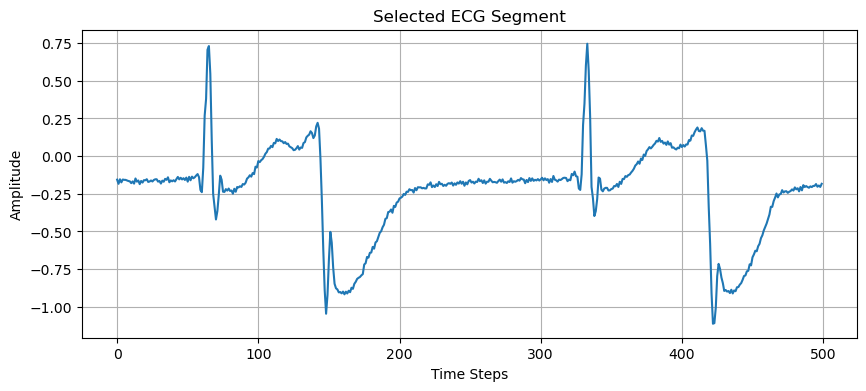

1/1 [==============================] - 0s 19ms/step
The prediction for this image is: 0
The actual label for this image is: 0


In [1]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Step 1: Load ECG data from the .mat file
mat_file_path = 'ECGData.mat'  # Replace with the path to your .mat file
ecg_data = sio.loadmat(mat_file_path)

# Extract the 'Data' and 'Labels' from the loaded ECGData
data = ecg_data['ECGData']['Data'][0, 0]    # Shape: (162, 65536)
labels = ecg_data['ECGData']['Labels'][0, 0]  # Shape: (162,)

# Step 2: Select 30 recordings of each signal type (ARR, CHF, NSR)
arr_data = data[:30, :]          # ARR (First 30 recordings)
chf_data = data[96:126, :]       # CHF (Recordings 97 to 126)
nsr_data = data[126:156, :]      # NSR (Recordings 127 to 156)

# Step 3: Define a function to create segments of the ECG signals
def create_segments(ecgdata, signal_length, num_segments):
    segments = []
    for i in range(ecgdata.shape[0]):  # For each ECG recording
        for k in range(num_segments):  # Create segments of fixed length
            segment = ecgdata[i, k * signal_length: (k + 1) * signal_length]
            segments.append(segment)
    return np.array(segments)

# Step 4: Segment the data
signal_length = 500  # Length of each signal segment
num_segments_per_recording = 10  # Number of segments per recording

arr_segments = create_segments(arr_data, signal_length, num_segments_per_recording)
chf_segments = create_segments(chf_data, signal_length, num_segments_per_recording)
nsr_segments = create_segments(nsr_data, signal_length, num_segments_per_recording)

# Combine the data
X = np.vstack([arr_segments, chf_segments, nsr_segments])

# Create corresponding labels: 0 for ARR, 1 for CHF, 2 for NSR
y = np.concatenate([np.zeros(arr_segments.shape[0]), 
                    np.ones(chf_segments.shape[0]), 
                    np.full(nsr_segments.shape[0], 2)])

# Step 5: Prepare the data for 1D CNN
X = X.reshape((X.shape[0], X.shape[1], 1))  # Add channel dimension
y = to_categorical(y, num_classes=3)  # One-hot encode labels

# Step 6: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 7: Build the 1D CNN model
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(signal_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Step 8: Train the model with callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_1d_cnn_model.h5', save_best_only=True)

history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, model_checkpoint],
    shuffle=True
)

# Step 9: Visualize training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Step 10: Evaluate the model
_, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Step 11: Prediction and classification report
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))

# Step 12: Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
print("Confusion Matrix:")
print(cm)

# Step 13: ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Step 14: Visualize a sample ECG signal
n = 20  # Index of the test sample to visualize
img = X_test[n]
plt.figure(figsize=(10, 4))
plt.plot(img.squeeze())
plt.title("Selected ECG Segment")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Step 15: Prediction for a single test sample
input_img = np.expand_dims(img, axis=0)  # Expand dims for prediction
prediction = model.predict(input_img)
predicted_label = np.argmax(prediction, axis=1)
true_label = y_test_labels[n]

print(f"The prediction for this image is: {predicted_label[0]}")
print(f"The actual label for this image is: {true_label}")